# KNN

In [2]:
import pandas as pd
import numpy as np
import shapely
import shapely.vectorized
import matplotlib.pyplot as plt
import json

from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from shapely.geometry import shape
from shapely.geometry.polygon import Polygon
from shapely import ops as shapely_ops

In [3]:
%matplotlib inline

In [4]:
np.random.seed(1)

In [1]:
import os
import sys

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
CODE_DIR = os.path.join(PROJECT_HOME, "code")
print("The code directory is located at", CODE_DIR)
sys.path.append(CODE_DIR)

The code directory is located at ./../../code


In [18]:
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries

## Extract Fingerprint Data for a Specific Floor

In [7]:
site_id = "5da138b74db8ce0c98bd4774"
floor_id = "B1"

fingerprint_files = list(glob(f"../../data/wifi_fingerprint_manual/train/{site_id}/{floor_id}/*_wifi_fingerprint.csv"))

* There are two approaches for testing the performance of `kNN`:
  1. Extract all fingerprints and put them into a single dataset. Then split the dataset into train and test datasets.
  2. Split tracks into train and test set.

* The first approach will cause unreliable results because some of the data in test dataset is leaked to the training step. This is obvious because of these fingerprints were collected from a track, in which waypoints were correlated.

* In this experiment, we use 80% of tracks for training models and 20% of tracks for testing model's performance.

In [8]:
train_files, test_files = train_test_split(fingerprint_files, test_size=0.2, random_state=42, shuffle=True)

In [9]:
print(f"The number of train files: {len(train_files)}")
print(f"The number of test files: {len(test_files)}")

The number of train files: 175
The number of test files: 44


In [10]:
def get_band(freq):
  d2400 = np.abs(freq - 2400)
  d5000 = np.abs(freq - 5000)
  band = np.zeros_like(freq)
  band[d2400 < d5000] = 2400
  band[d2400 >= d5000] = 5000
  return band


def extract_bssid_set(wifi_fingerprint_df_list):
  bssid_set = set()

  for df in wifi_fingerprint_df_list:
    unique_bssid_list = df["bssid"].unique().tolist()
    bssid_set.update(unique_bssid_list)

  return bssid_set


def extract_ssid_set(wifi_fingerprint_df_list):
  ssid_set = set()

  for df in wifi_fingerprint_df_list:
    unique_ssid_list = df["ssid"].unique().tolist()
    ssid_set.update(unique_ssid_list)

  return ssid_set


def create_fingerprint_vector(group_data: pd.DataFrame,
                              bssid_vector: np.ndarray,
                              not_seen_rssi: float = -1000) -> np.ndarray:
  v = np.zeros_like(bssid_vector, dtype=np.float32) + not_seen_rssi

  for bssid, rssi in group_data[["bssid", "rssi"]].values:
    v[bssid_vector == bssid] = rssi

  return v


def extract_fingerprint_df(fingerprint_files, wifi_band=(2400, 5000)):
  if isinstance(wifi_band, int):
    wifi_band = {wifi_band}

  wifi_fingerprint_df_list = [pd.read_csv(file) for file in fingerprint_files]

  # Adding frequency band
  for df in wifi_fingerprint_df_list:
    df["freq_band"] = get_band(df["freq"].values)

  wifi_fingerprint_fb_df_list = [
      df[df["freq_band"].isin(wifi_band)] for df in wifi_fingerprint_df_list
  ]

  bssid_set = extract_bssid_set(wifi_fingerprint_fb_df_list)
  ssid_set = extract_ssid_set(wifi_fingerprint_fb_df_list)
  print(f"The number of unique BSSIDs: {len(bssid_set)}")
  print(f"The number of unique SSIDs: {len(ssid_set)}")
  bssid_vector = np.array(list(bssid_set))

  fingerprint_tuples = []
  for df in tqdm(wifi_fingerprint_fb_df_list):
    for (sys_ts, x, y), group_data in df.groupby(["sys_ts", "x", "y"]):
      fingerprint_vector = create_fingerprint_vector(group_data,
                                                     bssid_vector,
                                                     not_seen_rssi=-1000)
      fingerprint_tuples.append((x, y, fingerprint_vector))

  print(f"The number of fingerprints: {len(fingerprint_tuples)}")

  return pd.DataFrame(fingerprint_tuples, columns=["x", "y", "v"]), bssid_vector

In [15]:
train_fingerprint_df, train_bssid = extract_fingerprint_df(train_files, wifi_band=2400)

The number of unique BSSIDs: 977
The number of unique SSIDs: 436


100%|██████████| 175/175 [00:04<00:00, 37.02it/s]

The number of fingerprints: 3849


In [16]:
test_fingerprint_df, test_bssid = extract_fingerprint_df(test_files, wifi_band=2400)

The number of unique BSSIDs: 711
The number of unique SSIDs: 315


100%|██████████| 44/44 [00:01<00:00, 32.93it/s]

The number of fingerprints: 938


## Extracting Floormap Data

In [17]:
floor_info, floor_map = read_floor_data(f"../../data/metadata/{site_id}/{floor_id}")

In [19]:
transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)

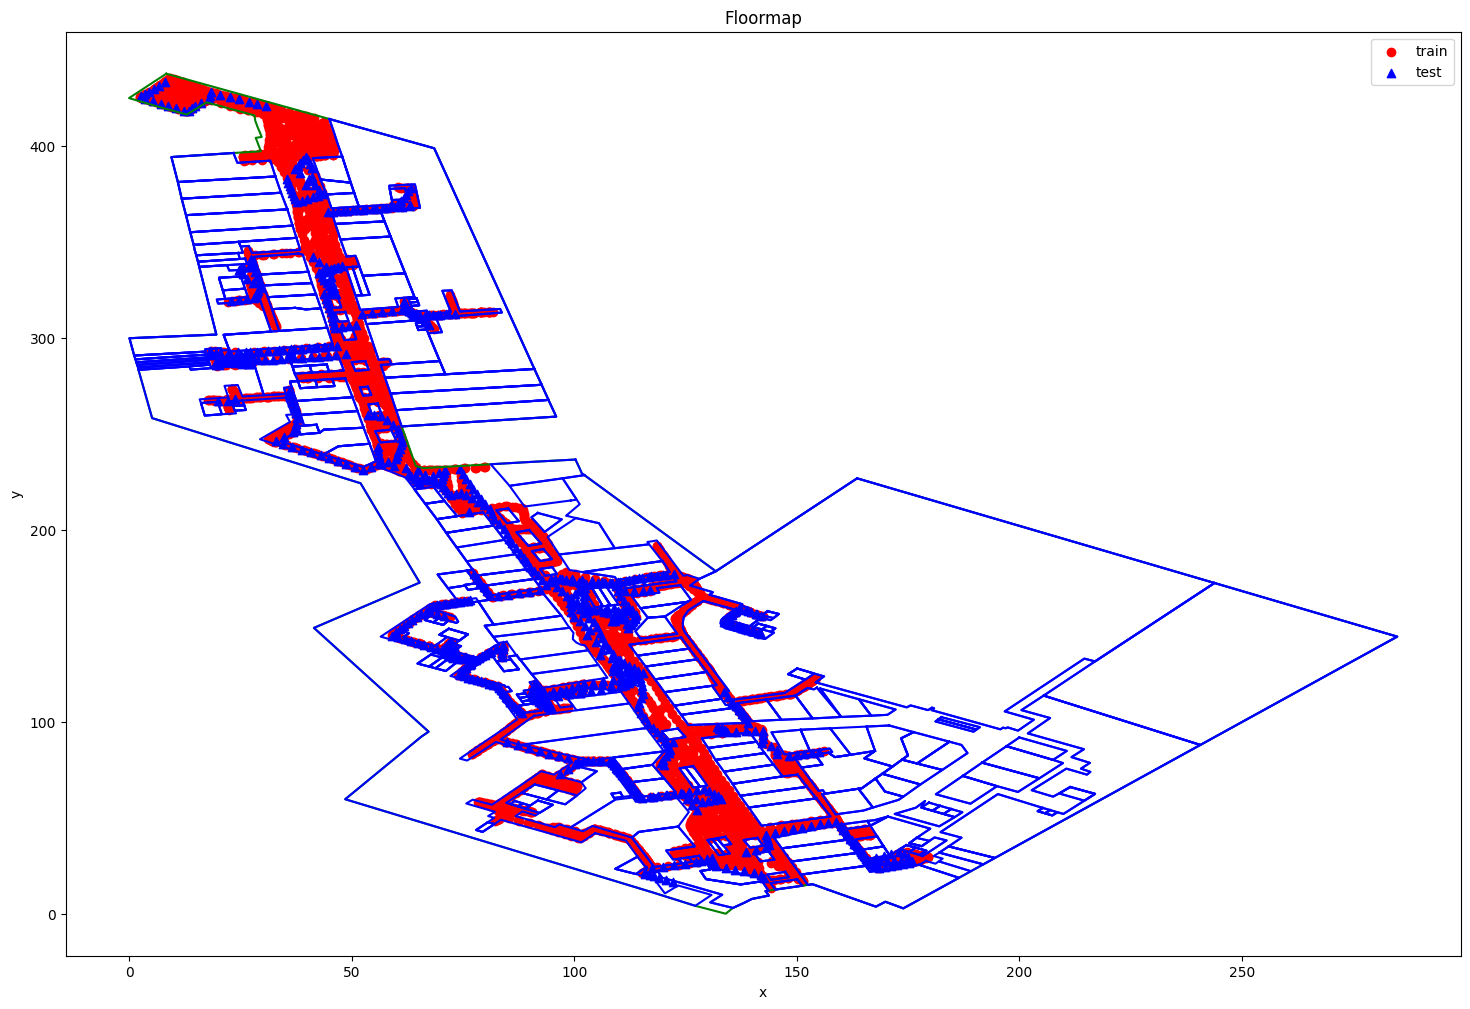

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(18, 12))

for floor_polygon in floor_polygons:
  x, y = floor_polygon.exterior.xy
  ax.plot(x, y, color="green")

for store_polygon in store_polygons:
  x, y = store_polygon.exterior.xy
  ax.plot(x, y, color="blue")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Floormap")

train_fingerprint_location = transform_func(train_fingerprint_df[["x",
                                                                  "y"]].values)
test_fingerprint_location = transform_func(test_fingerprint_df[["x",
                                                                "y"]].values)
ax.scatter(train_fingerprint_location[:, 0],
           train_fingerprint_location[:, 1],
           marker="o",
           color="red",
           label="train")
ax.scatter(test_fingerprint_location[:, 0],
           test_fingerprint_location[:, 1],
           marker="^",
           color="blue",
           label="test")
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

## KNN Regression

In [21]:
X_train = np.vstack(train_fingerprint_df["v"].values.tolist())
y_train = train_fingerprint_df[["x", "y"]].values

X_test = np.vstack(test_fingerprint_df["v"].values.tolist())
y_test = test_fingerprint_df[["x", "y"]].values

In [22]:
assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

* The first step is to translate the `X_test` in the test space into the associated vector in the train space.

In [23]:
def translator(test_bssid, train_bssid, unseen_rssi=-100):
  def c(X_test):
    X_test_translated = np.zeros((X_test.shape[0], train_bssid.shape[0])) + unseen_rssi
    for i, train_b in enumerate(train_bssid):
      indices = np.where(test_bssid == train_b)[0]

      if len(indices) == 1:
        X_test_translated[:, i] = X_test[:, indices[0]]
    
    return X_test_translated
  
  return c
    

In [24]:
train_test_translate = translator(test_bssid, train_bssid, unseen_rssi=-1000)

In [25]:
X_test_translated = train_test_translate(X_test)

* `kNN`

In [26]:
k_values = list(range(1, 21))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="distance")
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test_translated)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

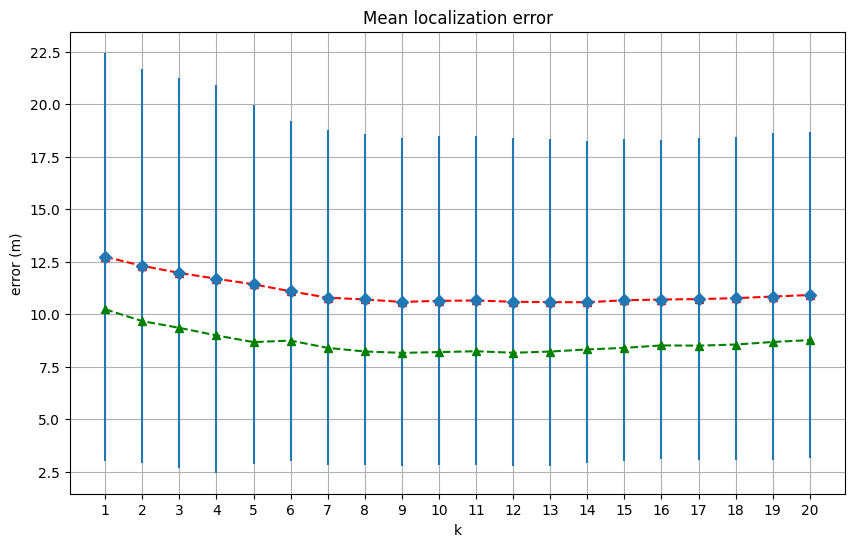

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()

plt.show()

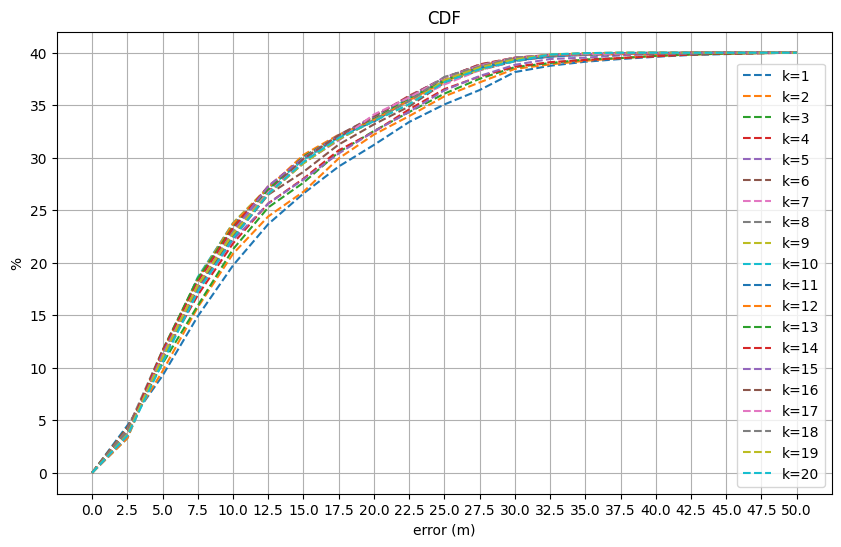

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

bins = [i / 20 for i in range(51)]

for k, errors in zip(k_values, error_list):
  pdf, bins = np.histogram(errors, bins=20, range=(0, 50), density=True)
  error_cdf = np.cumsum(pdf)
  error_cdf = np.array([0, *error_cdf.tolist()])
  ax.plot(bins, error_cdf * 100, ls="--", label="k={}".format(k))

ax.set_xlabel("error (m)")
ax.set_ylabel("%")
ax.set_xticks(bins)
ax.set_title("CDF")

ax.grid()
ax.legend()

plt.show()

* `PCA` + `kNN`

In [33]:
pca = PCA()
_ = pca.fit(X_train)
explained_variance_ratio_csum = np.cumsum(pca.explained_variance_ratio_)
n_components = np.where(explained_variance_ratio_csum > 0.95)[0][0] + 1
print(f"n_components={n_components}")

n_components=228


In [34]:
pca = PCA(n_components=n_components)
_ = pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test_translated)

In [35]:
k_values = list(range(1, 21))
model_list = []
error_list = []

for n_neighbors in k_values:
  knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights="distance")
  knn.fit(X_train_pca, y_train)
  y_pred = knn.predict(X_test_pca)
  errors = np.sqrt(np.sum((y_test - y_pred) ** 2, axis=1))
  
  model_list.append(knn)
  error_list.append(errors)

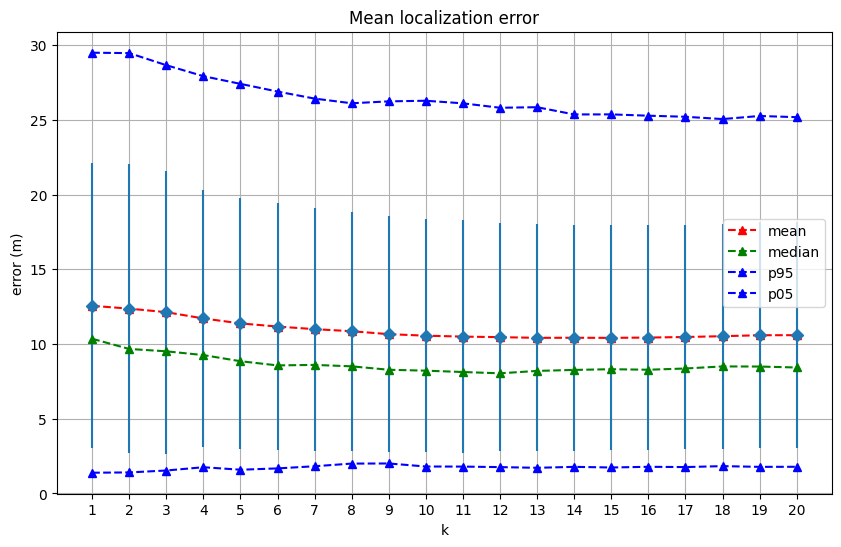

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

mean_errors = [errors.mean() for errors in error_list]
median_errors = [np.median(errors) for errors in error_list]
p95_errors = [np.percentile(errors, 95) for errors in error_list]
p05_errors = [np.percentile(errors, 5) for errors in error_list]
std_errors = [errors.std() for errors in error_list]

ax.errorbar(x=k_values, y=mean_errors, xerr=None, yerr=std_errors, fmt="D")
ax.plot(k_values, mean_errors, marker="^", ls="--", label="mean", color="red")
ax.plot(k_values, median_errors, marker="^", ls="--", label="median", color="green")
ax.plot(k_values, p95_errors, marker="^", ls="--", label="p95", color="blue")
ax.plot(k_values, p05_errors, marker="^", ls="--", label="p05", color="blue")

ax.set_xlabel("k")
ax.set_xticks(k_values)
ax.set_ylabel("error (m)")
ax.set_title("Mean localization error")

ax.grid()
ax.legend()

plt.show()

In [37]:
best_k_idx = np.argmin(mean_errors)
print(f"k={k_values[best_k_idx]}, mean_error={mean_errors[best_k_idx]:.2f}m, std_error={std_errors[best_k_idx]:.2f}m")

k=15, mean_error=10.41m, std_error=7.53m
